In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pdb
from tqdm import tqdm

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, './src')
from data import Dataset
from layers import BBBLinear

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [3]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.cuda.set_device(device)
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

set_seeds(1337)

In [4]:
class LastLayerBNN(nn.Module):
    def __init__(self, in_features, last_features=10, aux={}):
        super().__init__()

        self.layer1 = nn.Linear(in_features, 4*in_features)
        self.layer2 = nn.Linear(4*in_features, last_features)
        self.layer3 = BBBLinear(last_features, 1, aux=aux)

    def get_kl(self):
        return self.layer3.get_kl()

    def forward(self, input, sample=True):
        h = F.softplus(self.layer1(input))
        h = F.softplus(self.layer2(h))
        h = self.layer3(h, sample=sample)
        
        return h

In [5]:
class BNN(nn.Module):
    def __init__(self, in_features, last_features=10, aux={}):
        super().__init__()

        self.layer1 = nn.Linear(in_features, 4*in_features)
        self.layer2 = BBBLinear(4*in_features, last_features, aux=aux)
        self.layer3 = BBBLinear(last_features, 1, aux=aux)

    def get_kl(self):
        return self.layer2.get_kl() + self.layer3.get_kl()

    def forward(self, input, sample=True):
        h = F.softplus(self.layer1(input))
        h = F.softplus(self.layer2(h, sample=sample))
        h = self.layer3(h, sample=sample)
        
        return h

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [7]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['dataset_name'] = 'boston_housing'
args['var_family_type'] = 'IAF'
if args['dataset_name'].find('mnist') > -1:
    args['num_epoches'] = 201
    args['print_info'] = 50
    args['n_IS'] = 10000
    
    args['train_batch_size'] = 100
    args['val_dataset'] = 10000
    args['val_batch_size'] = 100
    args['test_batch_size'] = 100
else:
    args['n_IS'] = 1000
    args['num_epoches'] = 10001
    args['print_info'] = 1000
    args['train_batch_size'] = 100
    args['val_dataset'] = 100
    args['val_batch_size'] = 20
    args['test_batch_size'] = 10

In [8]:
dataset = Dataset(args)
dataset.in_features[0]

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 406


13

In [9]:
model = BNN(in_features=dataset.in_features[0], aux={'device': device}).to(device) #,  'var_family_type': 'IAF'

params = list(model.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, np.linspace(start=10, stop=args.num_epoches, num=50), gamma=0.5)

best_mse = float('inf')
best_KL = float('inf')
current_tol = 0


for ep in tqdm(range(args.num_epoches)):
    for x_train, y_train_labels in dataset.next_train_batch():
        preds = model(x_train)
        
        log_likelihood = torch.distributions.Normal(loc=preds, scale=torch.tensor(1., device=device,
                                                                                  dtype=args.torchType)).log_prob(y_train_labels).sum()
        KL = model.get_kl()
        elbo = log_likelihood - KL
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    if ep % args.print_info == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')
        score_total = []
        with torch.no_grad():
            for x_val, y_val_labels in dataset.next_val_batch():
                logits = model(x_val)
                score = ((logits - y_val_labels)**2).mean().cpu().numpy()
                score_total.append(score)
        print(f"Mean validation MSE at epoch number {ep} is {np.array(score_total).mean()}")
        print(f'Current KL is {KL.cpu().detach().numpy()}')

  0%|          | 6/10001 [00:00<22:18,  7.47it/s]

ELBO value is -7929425.0 on epoch number 0
Mean validation MSE at epoch number 0 is 6647023.0
Current KL is 5.161866188049316


 10%|█         | 1006/10001 [00:21<03:09, 47.57it/s]

ELBO value is -3269.390380859375 on epoch number 1000
Mean validation MSE at epoch number 1000 is 345.76171875
Current KL is 19.791433334350586


 20%|██        | 2006/10001 [00:42<02:45, 48.43it/s]

ELBO value is -316.26776123046875 on epoch number 2000
Mean validation MSE at epoch number 2000 is 107.82801818847656
Current KL is 160.89883422851562


 30%|███       | 3006/10001 [01:02<02:27, 47.34it/s]

ELBO value is -432.19329833984375 on epoch number 3000
Mean validation MSE at epoch number 3000 is 84.49354553222656
Current KL is 254.81521606445312


 40%|████      | 4006/10001 [01:23<02:02, 49.01it/s]

ELBO value is -313.2567443847656 on epoch number 4000
Mean validation MSE at epoch number 4000 is 84.4046859741211
Current KL is 254.6815643310547


 50%|█████     | 5006/10001 [01:43<01:41, 49.09it/s]

ELBO value is -719.907958984375 on epoch number 5000
Mean validation MSE at epoch number 5000 is 84.41857147216797
Current KL is 253.73782348632812


 60%|██████    | 6006/10001 [02:03<01:21, 49.09it/s]

ELBO value is -303.7187805175781 on epoch number 6000
Mean validation MSE at epoch number 6000 is 85.01899719238281
Current KL is 253.73794555664062


 70%|███████   | 7006/10001 [02:23<01:01, 49.05it/s]

ELBO value is -508.76177978515625 on epoch number 7000
Mean validation MSE at epoch number 7000 is 84.42676544189453
Current KL is 252.45509338378906


 80%|████████  | 8006/10001 [02:44<00:40, 49.00it/s]

ELBO value is -452.77532958984375 on epoch number 8000
Mean validation MSE at epoch number 8000 is 85.20829772949219
Current KL is 252.6101837158203


 90%|█████████ | 9006/10001 [03:04<00:20, 49.04it/s]

ELBO value is -333.96392822265625 on epoch number 9000
Mean validation MSE at epoch number 9000 is 84.99851989746094
Current KL is 256.0981750488281


100%|██████████| 10001/10001 [03:24<00:00, 48.85it/s]

ELBO value is -474.5859069824219 on epoch number 10000
Mean validation MSE at epoch number 10000 is 84.32112884521484
Current KL is 253.83470153808594


In [10]:
def plot_pred_to_true(args, model, dataset, name=''):
    '''
    The function plots prediction values (with predicted variance) versus true ones
    '''
    device = args.device
    torchType = args.torchType
    
    examples = torch.tensor([], device=device, dtype=torchType)
    true_ans = torch.tensor([], device=device, dtype=torchType)
    pred_ans = torch.tensor([], device=device, dtype=torchType)
    pred_std = torch.tensor([], device=device, dtype=torchType)
    
    with torch.no_grad():
        for val_batch, val_label in tqdm(dataset.next_val_batch()):
            pred_matrix = torch.empty((args.n_IS, val_batch.shape[0]), device=device, dtype=torchType)
            for i in range(args.n_IS):
                preds = model(val_batch)
                pred_matrix[i, :] = preds.view(-1)
            means = pred_matrix.mean(0)
            stds = pred_matrix.std(0)
            examples = torch.cat([examples, val_batch], dim=0)
            true_ans = torch.cat([true_ans, val_label.squeeze()], dim=0)
            pred_ans = torch.cat([pred_ans, means], dim=0)
            pred_std = torch.cat([pred_std, stds], dim=0)
        idx = torch.argsort(true_ans)
        examples = examples[idx].cpu().numpy()
        true_ans = true_ans[idx].cpu().numpy()
        pred_ans = pred_ans[idx].cpu().numpy()
        pred_std = pred_std[idx].cpu().numpy()
        
        plt.figure(figsize=(15, 8), dpi=300)
        plt.title(name)
        plt.fill_between(x=true_ans, y1=pred_ans+2*pred_std, y2=pred_ans-2*pred_std, alpha=0.5, label='std', )
        plt.plot(true_ans, pred_ans, '-..')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.axis('equal')
        plt.xlim(true_ans.min(), true_ans.max())
        plt.ylim(true_ans.min(), true_ans.max())
        plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
        plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(f'./figs/{name}.png', format='png')
        plt.show();
        return examples, true_ans, pred_ans, pred_std

5it [00:01,  2.72it/s]


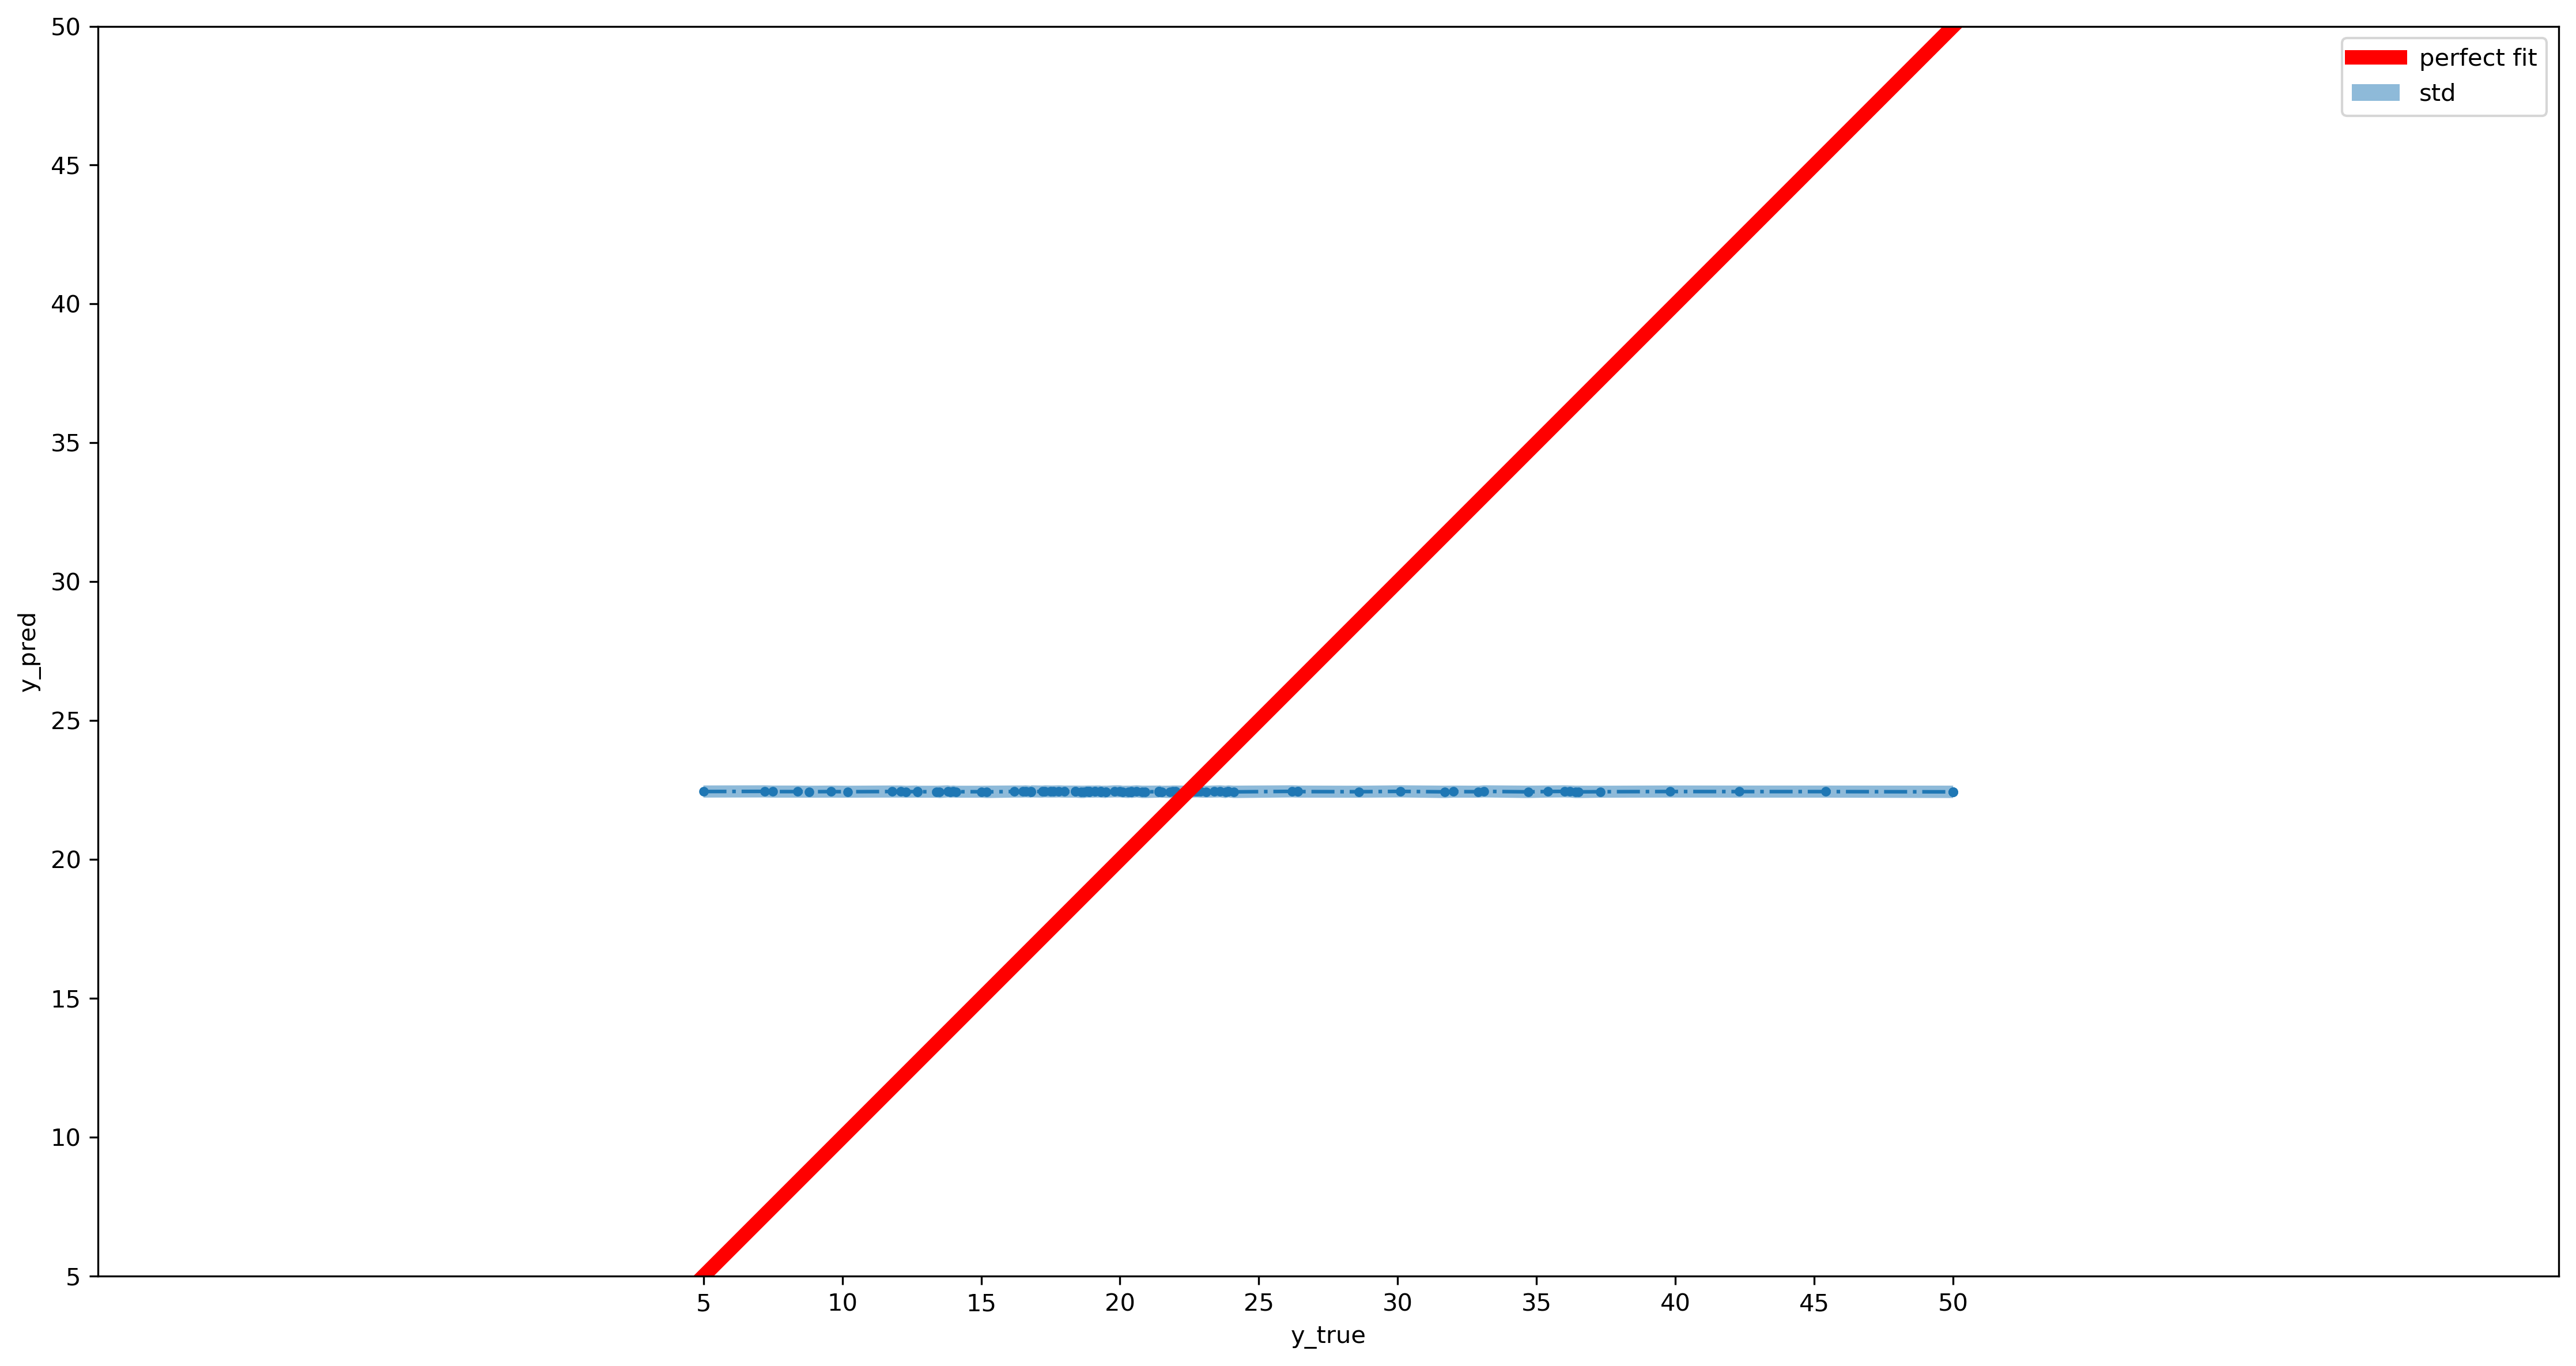

In [11]:
plot_pred_to_true(args, model, dataset);